In [1]:
import numpy as np
# import cv2
import pandas as pd
import os
import math

import tensorflow as tf

from keras.utils import Sequence
from keras.layers import Input, Flatten, Dense, BatchNormalization, Conv2D, Conv2DTranspose, Dropout, concatenate, Activation, Reshape, Permute, merge
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
import cv2
#%pylab inline

Using TensorFlow backend.


# Loading Data

In [2]:
%%time
initial_path = './images/'
X = []
for directory in sorted(os.listdir(initial_path)):
    path = initial_path + directory + '/Camera/RGB/'
    for image in sorted(os.listdir(path)):
        X.append(os.path.abspath(path+image))
print (len(X))

432000
CPU times: user 2.71 s, sys: 495 ms, total: 3.2 s
Wall time: 6.28 s


In [3]:
%%time
initial_path = './images/'
X_seg = []
for directory in sorted(os.listdir(initial_path)):
    path = initial_path + directory + '/Camera/SemanticSegmentation/'
    for image in sorted(os.listdir(path)):
        X_seg.append(os.path.abspath(path+image))
print (len(X_seg))

432000
CPU times: user 2.76 s, sys: 339 ms, total: 3.1 s
Wall time: 3.13 s


# Reading Labels

In [4]:
labels = pd.read_csv("target_values.csv", header=None, names=['frame','steer','throttle','brake','speed'])
labels.drop(['frame'],axis=1,inplace=True)
print (labels.shape)
labels.head()

(432000, 4)


,steer,throttle,brake,speed
0,-0.000238,1.0,0.0,0.000000e+00
1,-0.000239,1.0,0.0,2.548699e-09
2,-0.000239,1.0,0.0,5.095700e-09
3,-0.000239,1.0,0.0,7.641002e-09
4,-0.000239,1.0,0.0,1.018461e-08


In [5]:
labels.iloc[(labels.iloc[:,1]==0.5).values,1]=2

In [6]:
labels.throttle = labels.throttle.astype(int)
labels.brake = labels.brake.astype(int)

# Reading all images

In [7]:
x_train = np.zeros((432000,88,200,3), dtype='uint8')
x_seg = np.zeros((432000,88*200,1), dtype='uint8')

In [8]:
for idx,x in enumerate(tqdm(X)):
    x_train[idx] = cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB)[30:-22,:]

100%|██████████| 432000/432000 [09:25<00:00, 763.35it/s]


In [9]:
for idx,x in enumerate(tqdm(X_seg)):
    x_seg[idx] = np.load(x)[30:-22,:].reshape((-1,1))

100%|██████████| 432000/432000 [04:38<00:00, 1549.48it/s]


# Creating batches

In [10]:
batch_size = 256
total_images = 432000
num_batches = int(math.ceil(float(total_images)/float(batch_size)))
print (num_batches)

1688


In [11]:
indexes = np.arange(432000,dtype=np.int)

In [12]:
splits = np.array_split(indexes,num_batches)

# Creating Model

In [13]:
n_classes = 8

def computeIoU(y_pred_batch, y_true_batch):
    return np.mean(np.asarray([pixelAccuracy(y_pred_batch[i], y_true_batch[i]) for i in range(1024)])) 
 
def pixelAccuracy(y_pred, y_true):
    y_pred = np.argmax(np.reshape(y_pred,[n_classes,88,200]),axis=0)
    y_true = np.argmax(np.reshape(y_true,[n_classes,88,200]),axis=0)
    y_pred = y_pred * (y_true>0)
     
    return 1.0 * np.sum((y_pred==y_true)*(y_true>0)) /  np.sum(y_true>0)

In [14]:
def get_modified_pilotnet(image,speed):
    x = BatchNormalization()(image)
    #layer0
    x = Conv2D(24, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x1_before = Activation('relu')(x)
    x = Conv2D(24, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer='he_normal')(x1_before)
    x = BatchNormalization()(x)
    x1 = Activation('relu')(x)
    
    #layer1
    x = Conv2D(36, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(x1)
    x = BatchNormalization()(x)
    x2_before = Activation('relu')(x)
    x = Conv2D(36, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer='he_normal')(x2_before)
    x = BatchNormalization()(x)
    x2 = Activation('relu')(x)
    
    #layer2
    x = Conv2D(48, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(x2)
    x = BatchNormalization()(x)
    x3_before = Activation('relu')(x)
    x = Conv2D(48, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer='he_normal')(x3_before)
    x = BatchNormalization()(x)
    x3 = Activation('relu')(x)
    
    #layer3
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x3)
    x = BatchNormalization()(x)
    x4 = Activation('relu')(x)    

    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(x4)
    x = BatchNormalization()(x)
    x5 = Activation('relu')(x)
    
    # upsampling starts from here

    #up2
    y = Conv2DTranspose(48, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer='he_normal')(x5)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(48, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(merge([x3_before,y], mode = 'concat', concat_axis = 3))
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    
    #up1
    y = Conv2DTranspose(36, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(36, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(merge([x2_before,y], mode = 'concat', concat_axis = 3))
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    
    #up0
    y = Conv2DTranspose(24, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(24, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(merge([x1_before,y], mode = 'concat', concat_axis = 3))
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    
    y = Conv2D(n_classes, kernel_size=(1,1), padding='same', kernel_initializer='he_normal', name='Last_Transpose')(y)
    segmentation = Reshape((n_classes, (88*200)))(y)
    segmentation = Permute((2,1))(segmentation)
    segmentation = Activation('softmax', name='segmentation')(segmentation)
    

    # Predicting throttle, brake and steering
    flat = Flatten()(x5)
    
    dense_speed = Dense(128, kernel_initializer = 'he_normal')(speed)
    dense_speed = BatchNormalization()(dense_speed)
    dense_speed = Activation('relu')(dense_speed)
    
    dense_speed = Dense(256, kernel_initializer = 'he_normal')(dense_speed)
    dense_speed = BatchNormalization()(dense_speed)
    dense_speed = Activation('relu')(dense_speed)
    
    merged = concatenate([flat,dense_speed], axis = 1)
    
    dense_throttle = Dense(128, kernel_initializer = 'he_normal')(merged)
    dense_throttle = BatchNormalization()(dense_throttle)
    dense_throttle = Activation('relu')(dense_throttle)
    
    dense_throttle = Dense(64, kernel_initializer = 'he_normal')(dense_throttle)
    dense_throttle = BatchNormalization()(dense_throttle)
    dense_throttle = Activation('relu')(dense_throttle)
    
    dense_throttle = Dense(8, kernel_initializer = 'he_normal')(dense_throttle)
    dense_throttle = BatchNormalization()(dense_throttle)
    dense_throttle = Activation('relu')(dense_throttle)
    
    throttle = Dense(3, activation='softmax', kernel_initializer = 'he_normal', name = 'throttle')(dense_throttle)
    
    dense_brake = Dense(128, kernel_initializer = 'he_normal')(merged)
    dense_brake = BatchNormalization()(dense_brake)
    dense_brake = Activation('relu')(dense_brake)
    
    dense_brake = Dense(64, kernel_initializer = 'he_normal')(dense_brake)
    dense_brake = BatchNormalization()(dense_brake)
    dense_brake = Activation('relu')(dense_brake)
    
    dense_brake = Dense(8, kernel_initializer = 'he_normal')(dense_brake)
    dense_brake = BatchNormalization()(dense_brake)
    dense_brake = Activation('relu')(dense_brake)
    
    brake = Dense(1, activation='sigmoid', kernel_initializer = 'he_normal', name='brake')(dense_brake)
    
    dense_steering = Dense(128, kernel_initializer = 'he_normal')(merged)
    dense_steering = BatchNormalization()(dense_steering)
    dense_steering = Activation('relu')(dense_steering)
    
    dense_steering = Dense(64, kernel_initializer = 'he_normal')(dense_steering)
    dense_steering = BatchNormalization()(dense_steering)
    dense_steering = Activation('relu')(dense_steering)
    
    dense_steering = Dense(8, kernel_initializer = 'he_normal')(dense_steering)
    dense_steering = BatchNormalization()(dense_steering)
    dense_steering = Activation('relu')(dense_steering)
    
    steering = Dense(1, kernel_initializer = 'he_normal', name = 'steering')(dense_steering)
    
    model = Model(inputs = [image, speed], outputs = [segmentation, throttle, brake, steering])

    model.compile(optimizer = Adam(lr = 1e-3),loss_weights={'steering':1.0, 'throttle':1.0, 'brake':1.0, 'segmentation':0.45}, loss = {'steering':'mse', 'throttle':'sparse_categorical_crossentropy', 
                                        'brake':'binary_crossentropy', 'segmentation':'sparse_categorical_crossentropy'}, 
                 metrics = {'steering':'mae', 'throttle':'accuracy', 'brake':'accuracy'})

    return model

image_input = Input(shape=[88,200,3],name='rgb')
speed_input = Input(shape=[1],name='speed')
model = get_modified_pilotnet(image_input, speed_input)
model.summary()

/home/qzramiz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:42: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/qzramiz/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/qzramiz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/qzramiz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:58: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rgb (InputLayer)                (None, 88, 200, 3)   0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 88, 200, 3)   12          rgb[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 88, 200, 24)  1824        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 88, 200, 24)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [15]:
class CarlaSequence(Sequence):
    def __init__(self, X_train, Y_train, X_seg, batch_size, splits):
        self.x_img, self.y, self.y_seg = X_train, Y_train, X_seg
        self.batch_size = batch_size
        self.splits_length = len(splits)
        self.splits = splits

    def __len__(self):
        return self.splits_length

    def __getitem__(self, idx):
        idxes = self.splits[idx]
        x_speed = self.y[idxes,3].reshape((-1,1))
        y_steer = self.y[idxes,0].reshape((-1,1))
        y_throttle = self.y[idxes,1].reshape((-1,1))
        y_brake = self.y[idxes,2].reshape((-1,1))
        seg = self.y_seg[idxes].flatten()
        other_mask = np.zeros_like(seg)
        for i in [0,1,2,3,9,11]:
            other_mask = np.add(other_mask,seg==i)
        seg[other_mask==1] = 0
        seg[seg==4] = 1
        seg[seg==5] = 2
        seg[seg==6] = 3
        seg[seg==7] = 4
        seg[seg==8] = 5
        seg[seg==10] = 6
        seg[seg==12] = 7
        return {'rgb':self.x_img[idxes], 'speed':x_speed}, {'steering' : y_steer*3.0, 'throttle':y_throttle, 'brake':y_brake, 'segmentation':seg.reshape((idxes.shape[0],88*200,1))}

In [16]:
train_gen = CarlaSequence(x_train,labels.values,x_seg,batch_size,splits)

In [17]:
x_train[splits[0]].shape

(256, 88, 200, 3)

In [18]:
np.unique(train_gen.__getitem__(0)[1]['segmentation'])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [ ]:
model_filename= os.path.join('model_checkpoints', 'model.{epoch:03d}-{loss:.4f}.h5')
checkpoint = ModelCheckpoint(model_filename,monitor='loss',verbose=0,save_best_only=True)
stopping = EarlyStopping(monitor='loss', min_delta=0.00010, patience=10, verbose=1, mode='min')

In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch=num_batches,epochs=100,callbacks=[checkpoint,stopping], 
                               max_queue_size=32,workers=6)

Epoch 1/100
  13/1688 [..............................] - ETA: 1:48:28 - loss: 0.5286 - segmentation_loss: 0.3047 - throttle_loss: 0.2387 - brake_loss: 0.1400 - steering_loss: 0.0128 - throttle_acc: 0.9111 - brake_acc: 0.9525 - steering_mean_absolute_error: 0.0700

In [23]:
model.save('sementic_segmentation.h5')

In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/qzramiz/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


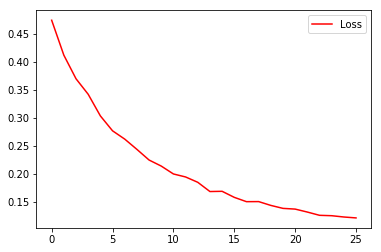

In [28]:
plt.plot(np.arange(len(model.history.history['loss'])),model.history.history['loss'],color= 'r',label = 'Loss')
plt.legend()

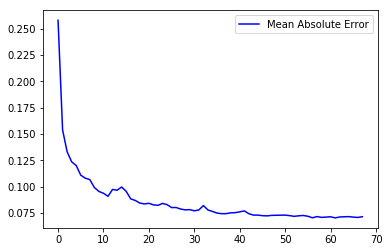

In [16]:
plt.plot(np.arange(len(history.history['loss'])),history.history['mean_absolute_error'],color= 'b',label = 'Mean Absolute Error')
plt.legend()